# Hausarbeit im Seminar Textanalyse WiSe 22/23
## Research Question

Wo sind die Parteien der UNi Wahlen in Göttingen im Vergleich zu Bundestagsparteien auf einer Links-Rechts Skala einzuordnen?

## Vorbereitung
Zunächst werden die Parteien definieiert und die Wahlprogramme (soweit vorhanden) eingelsen.

In [78]:
# import modules
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from wordscores3 import Wordscores
import matplotlib.pyplot as plt

In [79]:
PARTIES = [
    "ALL_BB",
    "GDF",
    "GHG",
    "JUSO",
    "LHG",
    "LISTE_VOLT",
    "NORDCAMPUS",
    "RCDS"
]

PROGRAMS = {}

for party in PARTIES:
    with open(f"{party}.txt", "r", encoding="utf-8") as f:
        file_content = f.read()
        PROGRAMS[party] = file_content

df = pd.DataFrame(PROGRAMS.items(), columns=["party", "program"])

# MARPOR data for referance texts
df_afd = pd.read_csv("AfD2021.csv")
text = " ".join(df_afd.text)
new_row = ["AFD", text]
df.loc[len(df)] = new_row

df_afd = pd.read_csv("Linke2021.csv")
text = " ".join(df_afd.text)
new_row = ["LINKE", text]
df.loc[len(df)] = new_row


df

,party,program
0,ALL_BB,"test test test Email sent, waiting for response"
1,GDF,Hochschulpolitik - Nicht mehr und nicht wenige...
2,GHG,"Liebe Studis, \nEs ist wieder so weit, die Hoc..."
3,JUSO,"Liebe Wähler*innen,\nvor euch seht ihr unser W..."
4,LHG,AStA-Beiträge senken\nAllgemeine Studiengebühr...
5,LISTE_VOLT,"Volt & Die LISTE verstehen sich als linkes, pr..."
6,NORDCAMPUS,Mehr interdisziplinäre Zusammenarbeit\nViele S...
7,RCDS,Auslandsstudium\nWer ein Semester im Ausland v...
8,AFD,Deutschland. Aber normal. Programm der Alterna...
9,LINKE,"Zeit zu handeln! Für soziale Sicherheit, Fried..."


## Data Cleaning
Im nächsten Schritt werden die Wahlprogramme gereinigt. Das Bedeutet, dass einige, für die Analyse unwichtige oder störende, Elemente gelöscht werden. Darunter zählen:
- Zeilenumbrüche
- großbuchstaben (werden klein geschrieben)
- anderes

In [80]:
# stopwords definieren
custom_stopwords = ["test"]
stopwords_used = stopwords.words("german") + custom_stopwords

# lemmatization setup
nlp = spacy.load('de_core_news_sm')


for i, prog in df.program.items():
    print(f"{i+1}/{len(df.program)}...")
    # lemma
    nlp_doc = nlp(prog)
    lemma_list = [x.lemma_ for x in nlp_doc]

    # remove stopwords and lower
    no_stopwords = [word.lower() for word in lemma_list if word.lower() not in stopwords_used]

    # remove short tokens
    min_len = 3
    new_list = [word for word in no_stopwords if len(word) >= min_len]


    # save to df
    df.program[i] = new_list


df.program

1/10...
2/10...
3/10...
4/10...
5/10...
6/10...
7/10...
8/10...
9/10...
10/10...


0               [email, senen, waiting, for, response]
1    [hochschulpolitik, mehr, weniger, hochschulpol...
2    [liebe, studi, weit, hochschulwahle, stehen, 1...
3    [lieb, wähler*innen, sehen, wahlprogramm, hoch...
4    [asta-beitrag, senken, allgemein, studiengebüh...
5    [volt, liste, verstehen, linkes, progressiv, q...
6    [mehr, interdisziplinär, zusammenarbeit, viele...
7    [auslandsstudium, wer, semester, ausland, verb...
8    [deutschland, normal, programm, alternative, f...
9    [zeit, handeln, sozial, sicherheit, frieden, k...
Name: program, dtype: object

## Wordscores berechnen

In [81]:
def create_word_frequency_matrix(index: int) -> pd.DataFrame:
    absolute_freq = pd.Series(df.program[index]).value_counts()
    relative_freq = pd.Series(df.program[index]).value_counts(normalize=True)
    word_freq_df = pd.DataFrame({
        "abs_freq": absolute_freq,
        "rel_freq": relative_freq
    })

    return(word_freq_df)

for i in range(len(df)):
    create_word_frequency_matrix(i).to_csv(f"inputdata/{df.party[i]}.csv", header=False)

#create_word_frequency_matrix(8).to_csv("inputdata/referenceCaseAfd.csv",header=False)
# create_word_frequency_matrix(9).to_csv("inputdata/referenceCaseLinke.csv",header=False)



In [82]:
MARPOR_RILE_2019 = {
    "GRÜNE": -21.038,
    "LINKE": -36.167,
    "SPD": -24.673,
    "FDP": 0.266,
    "CDU": 3.495,
    "AFD": 26.048
}

A_r = pd.DataFrame({'LINKE': MARPOR_RILE_2019["LINKE"], #TODO change values
                   # 'referenceCase2': 5.0, 
                   'AFD': MARPOR_RILE_2019["AFD"]},
                   index = ['score'])

W = Wordscores(A_r=A_r)

results = W.run()[1:]
print(results)

#GDF         -8.817810
#GHG         -9.402269
#JUSO        -9.122436
#LHG         -5.933416
#LISTE_VOLT -10.391655
#NORDCAMPUS  -8.918255
#RCDS        -5.956641

c:\Users\User\Desktop\Uni\WiSe 22-23\Empirische Demokratieforschung\Seminar_Methoden_der_Analyse_politischer_Texte_und_ihre_Anwendung\python_code\hausarbeit\wordscores3.py:56: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.P_wr = self.F_wr.iloc[:, 1:].div(self.F_wr.sum(axis = 1), axis = 0)


                score
GDF         -8.817810
GHG         -9.402269
JUSO        -9.122436
LHG         -5.933416
LISTE_VOLT -10.391655
NORDCAMPUS  -8.918255
RCDS        -5.956641


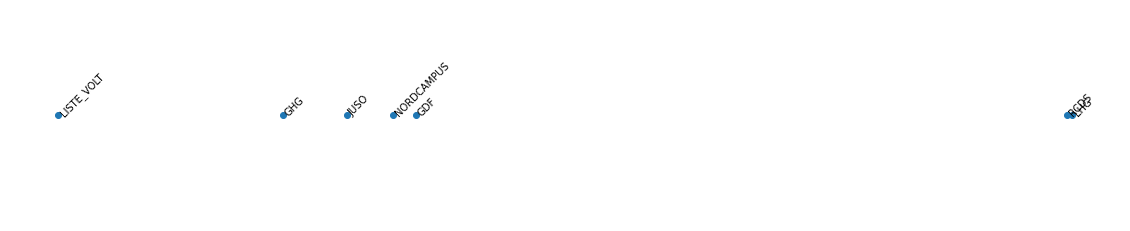

In [83]:
fig, ax = plt.subplots()
# plt.rcParams["figure.figsize"] = (20,4)

x = results.score
y = [0] * len(results)
ax.scatter(x, y)
# ax.axis([1, 10, 0, 0])
txt = results.index
for i, txt in enumerate(txt):
    ax.annotate(txt, (x[i], y[i]), rotation=45)
ax.axis("off")
plt.show()



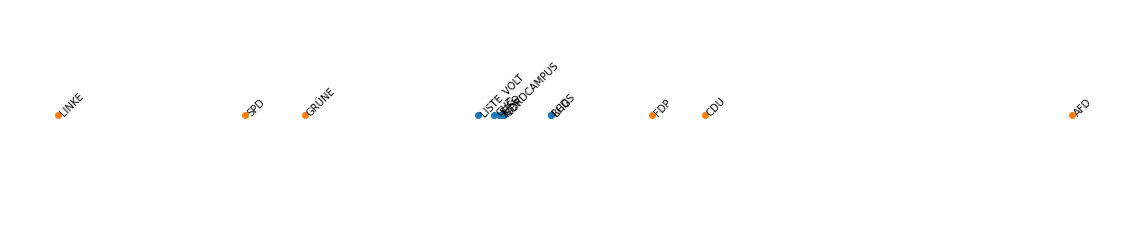

In [84]:
fig, ax = plt.subplots()
# plt.rcParams["figure.figsize"] = (20,4)

x = results.score
y = [0] * len(results)
ax.scatter(x, y)
# ax.axis([1, 10, 0, 0])
txt = results.index
for i, txt in enumerate(txt):
    ax.annotate(txt, (x[i], y[i]), rotation=45)
ax.axis("off")

# add bundestag parties
p_names = MARPOR_RILE_2019.keys()
x_bund = [MARPOR_RILE_2019[p_name] for p_name in p_names]
y_bund = [0] * len(x_bund) # 
ax.scatter(x_bund, y_bund)


for i, p_name in enumerate(p_names):
    ax.annotate(p_name, (x_bund[i], y_bund[i]), rotation=45)

plt.show()

Textskalierungsvervahren sind explorativer, eigentlich cool
